## Variational Autoencoder simples com CONVoluções utilizando o MNIST


## imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import image
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import BatchNorm1d
from torch.nn import BatchNorm2d
from torch.nn import ConvTranspose2d
from torch.nn import ReLU
from torch.nn import Softmax, Tanh, Sigmoid
from torch.nn import Module
from torch.nn import MSELoss
from torch.nn import BCELoss, BCEWithLogitsLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.optim import SGD, Adam, RMSprop 
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
  
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.utils import save_image, make_grid

#pip install torchinfo
from torchinfo import summary
from livelossplot import PlotLosses

In [ ]:
#Constants

#path para guardar o dataset
PATH = './'
PATH_TRAIN = './mnist_train.csv'
PATH_TEST = './mnist_test.csv'

BATCH_SIZE = 128

In [ ]:
#device management 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados.

In [ ]:
#buscar o dataset utilizando os CSVs e uma classe para o dataset

# definição classe para o dataset
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path_train, path_test):
        # ler o ficheiro csv para um dataframe
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        # separar os inputs e os outputs
        self.x_train = df_train.values[:, 1:]
        self.x_train = self.x_train.reshape(len(self.x_train), 1, 28, 28)
        xmax, xmin = self.x_train.max(), self.x_train.min()
        self.x_train  = (self.x_train - xmin)/(xmax - xmin)
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        self.x_test = self.x_test.reshape(len(self.x_test), 1, 28, 28)
        xmax, xmin = self.x_test.max(), self.x_test.min()
        self.x_test  = (self.x_test - xmin)/(xmax - xmin)
        self.y_test = df_test.values[:, 0]
        # garantir que os inputs e labels sejam floats
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')
        #print(self.x_train.shape)
        #print(self.y_train.shape)
        #print(self.x_train)
        #print(self.y_train)
        
    # numero de casos de treino no dataset
    def __len_train__(self):
        return len(self.x_train)
     # numero de casos de teste no dataset
    def __len_test__(self):
        return len(self.x_test)
    
    # retornar um caso
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]
     # retornar um caso
    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    # retornar indeces para casos de treino de de teste em formato flat (vetor)
    def get_splits(self):
        x_train  = torch.from_numpy(np.array(self.x_train))
        y_train  = torch.from_numpy(np.array(self.y_train))
        x_test  = torch.from_numpy(np.array(self.x_test))
        y_test  = torch.from_numpy(np.array(self.y_test))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        test = torch.utils.data.TensorDataset(x_test,y_test)
        return train, test 

# preparar o dataset
def prepare_data_flat(path_train, path_test):
    # criar uma instancia do dataset
    dataset = CSVDataset(path_train, path_test)
    # calcular split
    train, test = dataset.get_splits()
    # preparar data loaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True) #32 len(train)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

# preparar os dados
train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

torch.Size([128, 1, 28, 28])


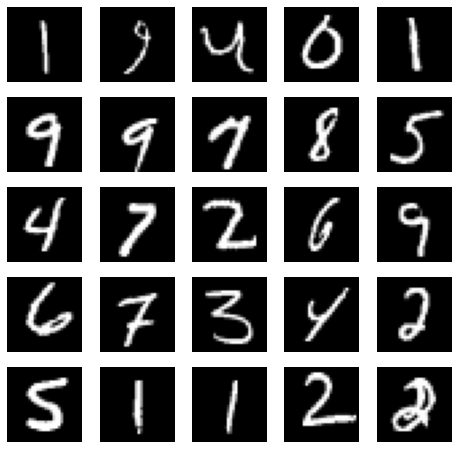

In [ ]:
#Visualização das imagens

def visualize_mnist_images_flat(dl):
    # get one batch of images
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    #inputs = inputs.reshape(len(inputs), 1, 28, 28)
    # plot some images
    plt.figure(figsize=(8,8))
    for i in range(25):
        # define subplot

        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(b=None)
        # plot raw pixel data
        plt.imshow(inputs[i][0], cmap='gray')
    # show the figure
    plt.show()

visualize_mnist_images_flat(test_dl)

## 2. Definir o Modelo.

In [ ]:
import models_mnist #modulo python com os modelos    
#gravado no ficheiro: model= torch.load('VAE_CONV_MNIST.pth')

model = models_mnist.VAE_CONV()
#visualizar a rede
print(summary(model, input_size=(BATCH_SIZE,  1,28,28), verbose=0)) #verbose=2 Show weight and bias layers in full detail
#model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [128, 32, 28, 28]         320
├─Conv2d: 1-2                            [128, 64, 14, 14]         18,496
├─Conv2d: 1-3                            [128, 64, 14, 14]         36,928
├─Conv2d: 1-4                            [128, 64, 14, 14]         36,928
├─Linear: 1-5                            [128, 32]                 401,440
├─Linear: 1-6                            [128, 32]                 401,440
├─Linear: 1-7                            [128, 12544]              413,952
├─ConvTranspose2d: 1-8                   [128, 32, 29, 29]         18,464
├─Conv2d: 1-9                            [128, 1, 28, 28]          129
Total params: 1,328,097
Trainable params: 1,328,097
Non-trainable params: 0
Total mult-adds (G): 4.49
Input size (MB): 0.40
Forward/backward pass size (MB): 105.50
Params size (MB): 5.31
Estimated Total Size (MB): 111.21


## 3. Treinar o Modelo.

In [ ]:
# treino do modelo
def train_model(h5_file,train_dl, test_dl, model, loss_function, optimizer, scheduler, epochs):
    liveloss = PlotLosses() 
    for epoch in range(epochs):
        logs = {} 
        model.train()
        running_loss  = 0.0 
        for inputs, _ in train_dl: 
            inputs = inputs.to(device)
            outputs, mu, log_var, _ = model(inputs)
            loss = loss_function(outputs, inputs, mu, log_var)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_dl.dataset)
        logs['loss'] = epoch_loss*1000 #.item()      
        #Validation phase
        model.eval()
        running_loss  = 0.0
        for inputs, _ in test_dl: 
            inputs = inputs.to(device)
            outputs, mu, log_var, _ = model(inputs)
            loss = loss_function(outputs, inputs, mu, log_var)
            running_loss += loss.item()
        epoch_loss = running_loss / len(test_dl.dataset)
        logs['val_loss'] = epoch_loss*1000 #.item() 
        scheduler.step(epoch_loss) #callback a meio para atualizar lr
        epoch_lr = optimizer.param_groups[0]['lr'] #scheduler.get_last_lr()[0]
        logs['val_lr'] = epoch_lr 
        liveloss.update(logs) ##para visualizarmos o processo de treino
        liveloss.send() ##para visualizarmos o processo de treino
    torch.save(model,h5_file)

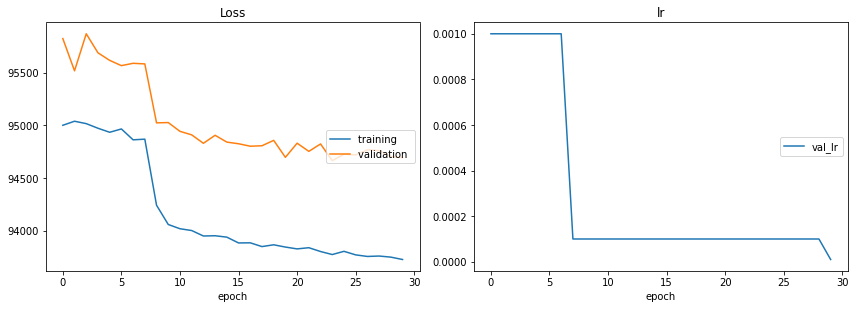

Loss
	training         	 (min: 93726.113, max: 170179.721, cur: 93726.113)
	validation       	 (min: 94664.288, max: 121452.771, cur: 94692.599)
lr
	val_lr           	 (min:    0.000, max:    0.001, cur:    0.000)
Tempo gasto: 486.9094452429563 segundos


In [ ]:
# treinar o modelo
import torch.nn.functional as F
EPOCHS = 30
LEARNING_RATE = 0.001

# definir o loss e a função de otimização
#loss_function = MSELoss() #neste caso queremos a diferença relativamente aos valores originais
#optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.5) #stochastic gradient descent

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = RMSprop(model.parameters(), lr=LEARNING_RATE)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.8)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)
starttime = time.perf_counter()
train_model('VAE_CONV_MNIST.pth', train_dl, test_dl, model, loss_function, optimizer, scheduler, EPOCHS)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

#0.298/ 0.293
#0.320/ 0.311
#148201.006/ 151111.608
#169

## 4. Usar o Autoencoder.

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


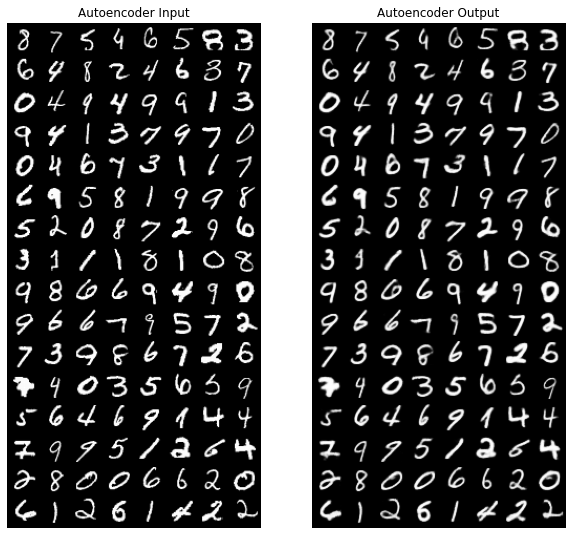

In [ ]:
def visualize(input_imgs, output_imgs):
    input_imgs=input_imgs.permute((1, 2, 0))
    output_imgs=output_imgs.permute((1, 2, 0))
    plt.subplots(1,2, figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('Autoencoder Input')
    plt.imshow(input_imgs, cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('Autoencoder Output')
    plt.imshow(output_imgs, cmap='gray')
    plt.show()

def test_image_reconstruction(model, test_dl):
    for batch in test_dl:
        img, _ = batch
        img = img.to(device)
        #img = img.view(img.size(0), -1)
        print(img.shape)
        outputs,_,_,_ = model(img)
        print(outputs.shape)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        print(outputs.shape)
        inputs = img.view(outputs.size(0), 1, 28, 28).cpu().data
        outputs = make_grid(outputs)
        inputs = make_grid(inputs)
        break 
    return inputs, outputs

model= torch.load('VAE_CONV_MNIST.pth')
inputs, outputs = test_image_reconstruction(model, train_dl)
visualize(inputs, outputs)

torch.Size([128, 1, 28, 28])
torch.float32
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


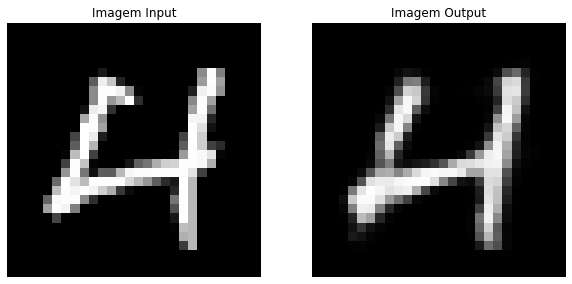

In [ ]:
# fazer uma previsão utilizando um caso

def make_prediction(model, img_list, idx): #img shape (784,1)

    print(img_list.shape)
    print(img_list.dtype) 
    img_list = img_list.to(device)
    prediction,_,_,_ = model(img_list)
    #prediction = model(img_list)
    print(prediction.shape)
    prediction = prediction.view(prediction.size(0), 1, 28, 28).cpu().data
    print(prediction.shape)
    img = img_list[idx].reshape(1,28, 28).cpu() #shape (1,1,28,28)
    plt.subplots(1,2, figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('Imagem Input')
    plt.imshow(img.permute((1, 2, 0)), cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('Imagem Output')
    plt.imshow(prediction[idx].permute((1, 2, 0)), cmap='gray')
    plt.show()
    
_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10) #receives an image tensor with shape (784,1)